In [1]:
import pandas as pd
import numpy as np
import catboost as cb
import pickle
import os
import gc
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import json
from tqdm.notebook import tqdm

from utilities import (
    RANDOM_STATE, TARGET_COL, N_FOLD, FOLD_STRAT_NAME,
)

INPUT_PATH = '../input/tabular-playground-series-oct-2021'
PATH_NOTEBOOK = '../input/preprocess-gpu'

TEST_PATH = [
#     '../input/xgboost-tuned',
#     '../input/lightgbm-tuned',
    '../input/catboost-benchmark',
#     '../input/nn-cat-binned',
    
]

In [2]:
with open(os.path.join(PATH_NOTEBOOK, 'feature_dic.pkl'), 'rb') as file:
    feature_dic = pickle.load(file)

#CONSTANT
FEATURE = feature_dic['feature']
CAT_COL = feature_dic['categorical']
NUMERIC_COL = feature_dic['numerical']

In [3]:
train = pd.read_pickle(
    os.path.join(PATH_NOTEBOOK, 'train_unscaled.pkl')
)

In [4]:
test = pd.read_pickle(
    os.path.join(PATH_NOTEBOOK, 'test_unscaled.pkl')
)

In [5]:
pl_data = train.copy()

for i, path in tqdm(enumerate(TEST_PATH)):

    sub = pd.read_csv(
        os.path.join(path, 'submission.csv')
    )
    
    sub['target_fold'] = (sub['target']>=.5).astype(int)

    #DEFINE FOLD same as PREPROCESS
    strat_fold = StratifiedKFold(n_splits = N_FOLD, random_state = RANDOM_STATE, shuffle = True)
    sub[FOLD_STRAT_NAME] = -1

    for j, (_, test_index) in enumerate(strat_fold.split(sub, sub['target_fold'])):
        sub.loc[test_index, FOLD_STRAT_NAME] = j

    pseudo_test = pd.concat([test, sub[[FOLD_STRAT_NAME, 'target']]], axis = 1)
    pl_data = pd.concat([pl_data, pseudo_test], axis = 0)

    gc.collect()

0it [00:00, ?it/s]

In [6]:
del train, test

In [7]:
FOLD_LIST = list(range(pl_data[FOLD_STRAT_NAME].nunique()))

gc.collect()

62

# TRAIN

In [8]:
params = {
    'iterations': 100000,
    'learning_rate': .005,
    'metric_period': 25,
    'depth': 6,
    'random_strength': 1,
    'loss_function': 'CrossEntropy',
    'random_state':RANDOM_STATE,
    'task_type' : 'GPU',
    'early_stopping_rounds' : 500,
}

In [9]:
score = 0
model_list = []

for i, fold_ in enumerate(FOLD_LIST):

    mask_train = (pl_data[FOLD_STRAT_NAME] != fold_)
    mask_test = (pl_data[FOLD_STRAT_NAME] == fold_)
    
    
    train_x, train_y = pl_data.loc[mask_train, FEATURE], pl_data.loc[mask_train, TARGET_COL]
    test_x, test_y = pl_data.loc[mask_test, FEATURE], pl_data.loc[mask_test, TARGET_COL]

    model = cb.CatBoostClassifier(**params)
    
    train_pool = cb.Pool(train_x, label= train_y, cat_features = CAT_COL)
    valid_pool = cb.Pool(test_x, label= test_y, cat_features = CAT_COL)
    
    model.fit(train_pool, eval_set = valid_pool, use_best_model=True)
        
    #evaluate score and save model for importance/prediction
    score_fold = model.get_best_score()['validation']['CrossEntropy'] 
    score += score_fold/N_FOLD
    
    model_list.append(model)
    
    print('\nFold: {}; Cross Entropy: {:.5f}\n'.format(fold_, score_fold))
    print('-'*50)
    print('\n\n\n')
    gc.collect()
    
print('CV-Cross Entropy: {:.5f}\n'.format(score))

0:	learn: 0.6910702	test: 0.6910675	best: 0.6910675 (0)	total: 56ms	remaining: 1h 33m 16s
25:	learn: 0.6463534	test: 0.6462803	best: 0.6462803 (25)	total: 1.82s	remaining: 1h 56m 30s
50:	learn: 0.6129348	test: 0.6128135	best: 0.6128135 (50)	total: 2.75s	remaining: 1h 29m 45s
75:	learn: 0.5879252	test: 0.5877810	best: 0.5877810 (75)	total: 3.56s	remaining: 1h 18m 1s
100:	learn: 0.5691866	test: 0.5690251	best: 0.5690251 (100)	total: 4.41s	remaining: 1h 12m 41s
125:	learn: 0.5551539	test: 0.5549848	best: 0.5549848 (125)	total: 5.22s	remaining: 1h 8m 55s
150:	learn: 0.5445120	test: 0.5443459	best: 0.5443459 (150)	total: 6.01s	remaining: 1h 6m 16s
175:	learn: 0.5363418	test: 0.5361806	best: 0.5361806 (175)	total: 6.8s	remaining: 1h 4m 19s
200:	learn: 0.5300043	test: 0.5298534	best: 0.5298534 (200)	total: 7.63s	remaining: 1h 3m 7s
225:	learn: 0.5250173	test: 0.5248749	best: 0.5248749 (225)	total: 8.45s	remaining: 1h 2m 12s
250:	learn: 0.5210667	test: 0.5209291	best: 0.5209291 (250)	total: 9.

# Feature importance

In [10]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = FEATURE


for fold_, model in enumerate(model_list):
    imp_temp = model.get_feature_importance()
    
    feature_importances['fold_{}'.format(fold_ + 1)] = imp_temp

Text(0.5, 1.0, '50 TOP feature importance over 5 average')

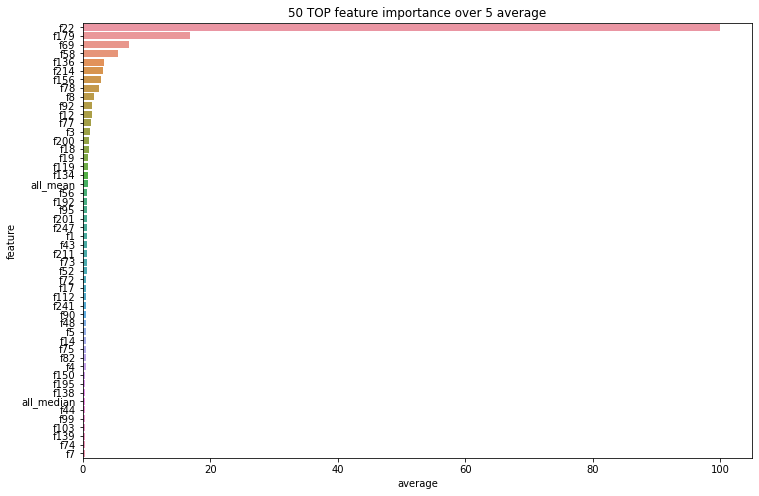

In [11]:
scaler = MinMaxScaler(feature_range=(0, 100))

average_importance = feature_importances.drop('feature', axis = 1).mean(axis=1)

feature_importances['average'] = scaler.fit_transform(X=pd.DataFrame(average_importance))
feature_importances = feature_importances.sort_values(by='average', ascending=False)

feature_importances[['feature', 'average']].to_csv('feature_importances.csv',index=False)

fig = plt.figure(figsize=(12,8))
sns.barplot(data=feature_importances.head(50), x='average', y='feature');
plt.title(f'50 TOP feature importance over {N_FOLD} average')

# TEST Blending

In [12]:
test = pd.read_pickle(
    os.path.join(PATH_NOTEBOOK, 'test_unscaled.pkl')
)

In [13]:
pred_test = np.zeros(test.shape[0])

for fold_, model in enumerate(model_list):
    pred_test += (model.predict_proba(test)[:, 1]/N_FOLD)

# SAVE RESULT

In [14]:
submission = pd.read_csv(os.path.join(INPUT_PATH, 'sample_submission.csv'))
submission['target'] = pred_test

submission.to_csv('submission.csv', index = False)